In [2]:
%%capture
!pip install --upgrade pip
!pip3 install --upgrade pip
!pip install opencv-rolling-ball
!pip install tifffile
!pip install tifffile --user
!pip3 install tifffile
!pip3 install tifffile --user
!sudo python3 -m pip install tifffile
import sys
sys.path.append('/home/ec2-user/.local/bin')

In [3]:
%%time
import sagemaker
from sagemaker import get_execution_role
from IPython.core.debugger import set_trace
role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::102554356212:role/service-role/AmazonSageMaker-ExecutionRole-20181129T100657
CPU times: user 549 ms, sys: 65.9 ms, total: 615 ms
Wall time: 3.81 s


In [4]:
bucket = sess.default_bucket()  
prefix = 'fresh_train_trial'
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'
print(bucket)

sagemaker-eu-west-1-102554356212


In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'semantic-segmentation', repo_version="latest")
print (training_image)

685385470294.dkr.ecr.eu-west-1.amazonaws.com/semantic-segmentation:latest


## Setup data

In [ ]:
# #from ImageJ: preprocessing
# dir = getDirectory("Choose a Directory ");
#    setBatchMode(true);
#    count = 0;
#    countFiles(dir);
#    n = 0;
#    processFiles(dir);
#    //print(count+" files processed");
   
#    function countFiles(dir) {
#       list = getFileList(dir);
#       for (i=0; i<list.length; i++) {
#           if (endsWith(list[i], "/"))
#               countFiles(""+dir+list[i]);
#           else
#               count++;
#       }
#   }

#    function processFiles(dir) {
#       list = getFileList(dir);
#       for (i=0; i<list.length; i++) {
#           if (endsWith(list[i], "/"))
#               processFiles(""+dir+list[i]);
#           else {
#              showProgress(n++, count);
#              path = dir+list[i];
#              processFile(path);
#           }
#       }
#   }

#   function processFile(path) {
#        if (endsWith(path, "raw.tif")) {
#            open(path);
#            //run("Invert");
# 		   run("16-bit");
#            run("Enhance Contrast...", "saturated=0.3 normalize equalize");
# 		   run("Subtract Background...", "rolling=50");
#            run("Size...", "width=1024 height=1024 average interpolation=Bilinear");
#            run("Gaussian Blur...", "sigma=3");
#            run("Sharpen");
#            save(path);
#            close();
#       }
#   }

### Prepare Hela Cell Dataset Ground Truth

In [ ]:
%%capture
#Hela cell dataset
import boto3
import numpy as np
from skimage import util 
from skimage.util import img_as_ubyte
from skimage import exposure,color, img_as_int
from skimage.io import imread as pngread
from skimage.io import imsave as pngsave
from skimage.segmentation import mark_boundaries
from tifffile import imsave,imread
import cv2
from rolling_ball_filter import rolling_ball_filter
import random
import threading

files = []
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3meadata = s3_resource.Bucket(name='meadata')
#remember to upload files
def proccesshelafiles(f, s3 = s3, sess = sess, bucket = bucket, prefix = prefix):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    if 'jpg' in f:
        file = f
        if 'segproj/hela_dataset_training_data/train/' in f:
            jpgpath = '/tmp/'+'hela_'+file.split('/')[-1].split('.')[0]+'_'+'raw.jpg'
            s3.meta.client.download_file('meadata', file, jpgpath)
            inverted_img = pngread(jpgpath)
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            image =  cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA) 
            pngsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=train_channel)
        elif 'segproj/hela_dataset_training_data/val/' in f:
            jpgpath = '/tmp/'+'hela_'+file.split('/')[-1].split('.')[0]+'_'+'raw.jpg'
            s3.meta.client.download_file('meadata', file, jpgpath)
            inverted_img = pngread(jpgpath)
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            image =  cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA) 
            pngsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=validation_channel)
    elif 'png' in f:
        file = f
        if 'segproj/hela_dataset_training_data/train_annotation/' in f:
            pngpath = '/tmp/'+'hela_'+file.split('/')[-1].split('.')[0]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = pngread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            pngsave(pngpath,im3, check_contrast=False)            
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/hela_dataset_training_data/val_annotation/' in f:
            pngpath = '/tmp/'+'hela_'+file.split('/')[-1].split('.')[0]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = pngread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            pngsave(pngpath,im3, check_contrast=False)            
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)

### Prepare Figure8 Ground Truth

In [ ]:
%%capture
#figure8
import boto3
import numpy as np
from skimage import util 
from skimage.util import img_as_ubyte
from skimage import exposure,color, img_as_int
from skimage.io import imread as pngread
from skimage.io import imsave as pngsave
from skimage.segmentation import mark_boundaries
from tifffile import imsave,imread
import cv2
from rolling_ball_filter import rolling_ball_filter
import random
import threading

files = []
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3meadata = s3_resource.Bucket(name='meadata')

def proccessfigure8files(f, s3 = s3, sess = sess, bucket = bucket, prefix = prefix):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    if 'tif' in f:
        file = f
        if 'segproj/training_data/train/' in f:
            jpgpath = '/tmp/'+'fig8_raw_'+file.split('/')[-2]+'_'+'raw.jpg'
            s3.meta.client.download_file('meadata', file, jpgpath.replace('jpg','tif'))
            inverted_img = imread(jpgpath.replace('jpg','tif'))
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(2**num - 1, 0))
#             image = util.invert(image)
            imsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=train_channel)
        elif 'segproj/training_data/val/' in f:
            jpgpath = '/tmp/'+'fig8_raw_'+file.split('/')[-2]+'_'+'raw.jpg'
            s3.meta.client.download_file('meadata', file, jpgpath.replace('jpg','tif'))
            inverted_img = imread(jpgpath.replace('jpg','tif'))
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(2**num - 1, 0))
#             image = util.invert(image)
            imsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=validation_channel)
    elif 'instances_ids.png' in f:
        file = f
        if 'segproj/training_data/train/' in f:
            pngpath = '/tmp/'+'fig8_raw_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = pngread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            pngsave(pngpath,im3, check_contrast=False)            
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/training_data/val/' in f:
            pngpath = '/tmp/'+'fig8_raw_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = pngread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            pngsave(pngpath,im3, check_contrast=False)            
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)

## Prepare Usiigaci Ground Truth (phase contrast)

In [ ]:
%%capture
#usiigaci
import boto3
import numpy as np
from skimage import util 
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.io import imread as pngread
from skimage.io import imsave as pngsave
from tifffile import imsave,imread
import cv2
from rolling_ball_filter import rolling_ball_filter
import random
import threading
from skimage.segmentation import mark_boundaries
from skimage import color
files = []
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3meadata = s3_resource.Bucket(name='meadata')

def proccessusiigacifiles(f, s3 = s3, sess = sess, bucket = bucket, prefix = prefix):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    if 'tif' in f:
        file = f
        if 'segproj/usiigaci_train_data/train/' in f:
            jpgpath = '/tmp/'+'usiigaci_'+file.split('/')[-2]+'_'+'raw.jpg'
            s3.meta.client.download_file('meadata', file, jpgpath.replace('jpg','tif'))
            inverted_img = util.invert(imread(jpgpath.replace('jpg','tif')))
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            image =  cv2.resize(img_as_ubyte(image), (1024,1024), interpolation = cv2.INTER_AREA)
#             image,_ = rolling_ball_filter(image, ball_radius = 20, spacing = 1, top=False)
            imsave(jpgpath,image)
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=train_channel)
        elif 'segproj/usiigaci_train_data/val/' in f:
            jpgpath = '/tmp/'+'usiigaci_'+file.split('/')[-2]+'_'+'raw.jpg'
            s3.meta.client.download_file('meadata', file, jpgpath.replace('jpg','tif'))
            inverted_img = util.invert(imread(jpgpath.replace('jpg','tif')))
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            image =  cv2.resize(img_as_ubyte(image), (1024,1024), interpolation = cv2.INTER_AREA)
#             image,_ = rolling_ball_filter(image, ball_radius = 20, spacing = 1, top=False)
            imsave(jpgpath,image)
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=validation_channel)
    elif 'instances_ids.png' in f:
        file = f
        if 'segproj/usiigaci_train_data/train/' in f:
            pngpath = '/tmp/'+'usiigaci_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = pngread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            pngsave(pngpath,im3, check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/usiigaci_train_data/val/' in f:
            pngpath = '/tmp/'+'usiigaci_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = pngread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            pngsave(pngpath,im3, check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)

## Prepare Lior's Ground Truth (manually adjusted MaskRCNN)

In [ ]:
%%capture
def proccessliorfiles(f, s3 = s3, sess = sess, bucket = bucket, prefix = prefix):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    if 'tif' in f:
        file = f
        file = file.replace('._','')
        if 'segproj/liorp_training_data/train/' in f:
            jpgpath = '/tmp/'+'liorp_raw_'+file.split('/')[-2]+'_'+'raw.jpg'
            s3.meta.client.download_file('meadata', file, jpgpath.replace('jpg','tif'))
            image = imread(jpgpath.replace('jpg','tif'))
            inverted_img =  cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA)
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            imsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=train_channel)
        elif 'segproj/liorp_training_data/val/' in f:
            jpgpath = '/tmp/'+'liorp_raw_'+file.split('/')[-2]+'_'+'raw.jpg'
            s3.meta.client.download_file('meadata', file, jpgpath.replace('jpg','tif'))
            image = imread(jpgpath.replace('jpg','tif'))
            inverted_img =  cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA)
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            imsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=validation_channel)
    elif 'instances_ids.png' in f:
        file = f
        file = file.replace('._','')
        if 'segproj/liorp_training_data/train/' in f:
            pngpath = '/tmp/'+'liorp_raw_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = pngread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            pngsave(pngpath,im3, check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/liorp_training_data/val/' in f:
            pngpath = '/tmp/'+'liorp_raw_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = pngread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            pngsave(pngpath,im3, check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)

### Prepare Pre-processed data

In [ ]:
# Add's filtered data to training set
import boto3
import numpy as np
from skimage import util 
from skimage.util import img_as_ubyte,img_as_uint
from skimage import exposure,color, img_as_int
from skimage.io import imread 
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
# from tifffile import imsave,imread
import cv2
from rolling_ball_filter import rolling_ball_filter
import random
import threading

files = []
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3meadata = s3_resource.Bucket(name='meadata')

def proccessfig8preprocfiles(f, s3 = s3, sess = sess, bucket = bucket, prefix = prefix):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    if 'tif' in f:
        file = f
        if 'segproj/fig8_preprocessed/train/' in f:
            pngpath = '/tmp/'+'fig8_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath.replace('png','tif'))
            inverted_img = imread(pngpath.replace('png','tif'))
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0,2**8 - 1))
            cv2.imwrite(pngpath.replace('png','jpg'),img_as_ubyte(image),[int(cv2.IMWRITE_JPEG_QUALITY), 100])
            sess.upload_data(path=pngpath.replace('png','jpg'), bucket=bucket, key_prefix=train_channel)
        elif 'segproj/fig8_preprocessed/val/' in f:
            pngpath = '/tmp/'+'fig8_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath.replace('png','tif'))
            inverted_img = imread(pngpath.replace('png','tif'))
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0,2**8 - 1))
            cv2.imwrite(pngpath.replace('png','jpg'),img_as_ubyte(image),[int(cv2.IMWRITE_JPEG_QUALITY), 100])
            sess.upload_data(path=pngpath.replace('png','jpg'), bucket=bucket, key_prefix=validation_channel)
    elif 'instances_ids.png' in f:
        file = f
        if 'segproj/fig8_preprocessed/train/' in f:
            pngpath = '/tmp/'+'fig8_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = imread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            cv2.imwrite(pngpath,im3,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])          
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/fig8_preprocessed/val/' in f:
            pngpath = '/tmp/'+'fig8_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = imread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            cv2.imwrite(pngpath,im3,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])            
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)

def proccessliorpreprocfiles(f, s3 = s3, sess = sess, bucket = bucket, prefix = prefix):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    if 'tif' in f:
        file = f
        file = file.replace('._','')
        if 'segproj/liorp_preprocessed/train/' in f:
            pngpath = '/tmp/'+'liorp_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath.replace('png','tif'))
            image = imread(pngpath.replace('png','tif'))
            inverted_img =  cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA)
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**8 - 1))
            cv2.imwrite(pngpath.replace('png','jpg'),img_as_ubyte(image),[int(cv2.IMWRITE_JPEG_QUALITY), 100])
            sess.upload_data(path=pngpath.replace('png','jpg'), bucket=bucket, key_prefix=train_channel)
        elif 'segproj/liorp_preprocessed/val/' in f:
            pngpath = '/tmp/'+'liorp_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath.replace('png','tif'))
            image = imread(pngpath.replace('png','tif'))
            inverted_img =  cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA)
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**8 - 1))
            cv2.imwrite(pngpath.replace('png','jpg'),img_as_ubyte(image),[int(cv2.IMWRITE_JPEG_QUALITY), 100])
            sess.upload_data(path=pngpath.replace('png','jpg'), bucket=bucket, key_prefix=validation_channel)
    elif 'instances_ids.png' in f:
        file = f
        file = file.replace('._','')
        if 'segproj/liorp_preprocessed/train/' in f:
            pngpath = '/tmp/'+'liorp_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = imread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            cv2.imwrite(pngpath,im3,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/liorp_preprocessed/val/' in f:
            pngpath = '/tmp/'+'liorp_'+file.split('/')[-2]+'_'+'raw.png'
            s3.meta.client.download_file('meadata', file, pngpath)
            im1 = imread(pngpath)
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = img_as_int(im)
            im3 = np.zeros([im2.shape[0],im2.shape[1]])
            im3 = im2[:,:,0]+im2[:,:,1]+im2[:,:,2]
            im3 = np.uint8((im3>0))
            im3 =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)                 
            cv2.imwrite(pngpath,im3,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)

In [ ]:
%%capture
# Run process functions (raw and filtered versions of fig8 and liorP)
def procfilepar(key):
    proccessliorpreprocfiles(key)
    proccessliorfiles(key)
    proccessfigure8files(key)
    proccessfig8preprocfiles(key)
    proccessusiigacifiles(key)
    proccesshelafiles(key)
    
keys = [obj.key for obj in s3meadata.objects.all()]
for key in keys:
    t = threading.Thread(target = procfilepar, args=(key,)).start()
#     proccessliorpreprocfiles(key)
#     proccessliorfiles(key)
#     proccessfigure8files(key)
#     proccessfig8preprocfiles(key)

### Crop dataset images around labeled areas

In [ ]:
from math import floor
import os

def cropimage(image, best_box = None):
    try:
        imgray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    except:
        print(image.shape)
        imgray = image
        pass
    
    if best_box is None:
        ret,thresh = cv2.threshold(np.uint8(imgray>0),0,255,cv2.THRESH_BINARY_INV)
        dilated=cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)))
        contours,_ = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        new_contours=[]
        for c in contours:
            if cv2.contourArea(c)<256*256:
                new_contours.append(c)
        best_box=[-1,-1,-1,-1]
        for c in new_contours:
            x,y,w,h = cv2.boundingRect(c)
            if best_box[0] < 0:
                best_box=[x,y,x+w,y+h]
            else:
                if x<best_box[0]:
                    best_box[0]=x
                if y<best_box[1]:
                    best_box[1]=y
                if x+w>best_box[2]:
                    best_box[2]=x+w
                if y+h>best_box[3]:
                    best_box[3]=y+h
    if (np.abs(best_box[2]-best_box[0])>100)&(np.abs(best_box[3]-best_box[1])>100):
        roi = imgray[best_box[1]:best_box[3], best_box[0]:best_box[2]]
        roi = roi[0:np.min(roi.shape), 0:np.min(roi.shape)]
    else:
        print(best_box)
        roi = imgray
    delta_w = 1024 - roi.shape[1]
    delta_h = 1024 - roi.shape[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    roi = cv2.copyMakeBorder(roi, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)
#     roi =  cv2.resize(roi, (256,256), interpolation = cv2.INTER_AREA)
    return(roi, best_box)

def performcrop(key, bucket  = bucket, prefix = prefix ):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    imsavepath = "/tmp/"+key.split('/')[-1]
    maskkey = key.replace('train/',"train_annotation/").replace('val/','val_annotation/').replace('jpg','png')
    masksavepath = "/tmp/"+maskkey.split('/')[-1]
    try:
        s3.meta.client.download_file(bucket, key, imsavepath)
        s3.meta.client.download_file(bucket, maskkey , masksavepath)
    except:
        try:
            s3.meta.client.delete_object(Bucket = bucket, Key =  maskkey)
            s3.meta.client.delete_object(Bucket = bucket, Key =  key)
        except:
            pass
        pass
        
    if os.stat(imsavepath).st_size > 2000:
        mask,box = cropimage(cv2.imread(masksavepath))
        im,_ = cropimage(cv2.imread(imsavepath), best_box = box)
        cv2.imwrite(imsavepath,im)
        cv2.imwrite(masksavepath,mask)
        if 'train/' in key:
            sess.upload_data(path=imsavepath, bucket=bucket, key_prefix=train_channel)
            sess.upload_data(path=masksavepath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'validation/' in key:
            sess.upload_data(path=imsavepath, bucket=bucket, key_prefix=validation_channel)
            sess.upload_data(path=masksavepath, bucket=bucket, key_prefix=validation_annotation_channel)

In [ ]:
keys = [obj.key for obj in s3_resource.Bucket(name=bucket).objects.all() if ('jpg' in obj.key and prefix in obj.key)]
for key in keys:
#     performcrop(key)
     t = threading.Thread(target = performcrop, args=(key,)).start()

### Delete all files without a matching image-annotation

In [ ]:
def removeunmatched(s3_resource = s3_resource, prefix = prefix, bucket = bucket):
    keys = [obj.key for obj in s3_resource.Bucket(name=bucket).objects.all()]
    imkeys = set([str(key).split('/')[-1] for key in keys if ('jpg' in key and prefix in key)])
    maskkeys = set([str(key).split('/')[-1].replace('png','jpg') for key in keys if ('png' in key and prefix in key)])
    todelete = [l.replace('jpg','png') for l in list(maskkeys-(imkeys&maskkeys))]+list(imkeys-(imkeys&maskkeys))
    remove = [key for key in keys if any([t in key for t in todelete])]
    [boto3.client('s3').delete_object(Bucket=bucket, Key=r) for r in remove]
removeunmatched()

### Remove samples with few segmentations

In [ ]:
import numpy as np
import boto3
import numpy as np
from skimage import util 
from skimage.util import img_as_ubyte
from skimage import exposure,color, img_as_int
from skimage.io import imread as pngread
from skimage.io import imsave as pngsave
from skimage.segmentation import mark_boundaries
from tifffile import imsave,imread
import cv2
from rolling_ball_filter import rolling_ball_filter
import random
import threading
import pandas as pd
import matplotlib.pyplot as plt

files = []
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3meadata = s3_resource.Bucket(name='meadata')
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'
keys = [obj.key for obj in s3_resource.Bucket(name=bucket).objects.all() if ('png' in obj.key and prefix in obj.key)]
segs = []
empties = []
for key in keys:
    masksavepath = "/tmp/"+key.split('/')[-1]
    s3.meta.client.download_file(bucket, key , masksavepath)
    mask = cv2.imread(masksavepath)
    segs.append([np.sum(mask==1)])
    empties.append([np.sum(mask==0)])

ratio = ((np.asarray(segs)/np.asarray(empties))*100).ravel()
thresh = np.round(np.mean(ratio)-np.std(ratio))
plt.hist(ratio)
plt.show()
df = pd.DataFrame({'key':keys, 'ratio':ratio,'empty':ratio<thresh})
removesamples = df['key'].loc[np.where(df['empty'].values)].values
for removeme in removesamples:
    boto3.client('s3').delete_object(Bucket = bucket, Key = removeme)
    boto3.client('s3').delete_object(Bucket = bucket, Key = removeme.replace('_annotation/','/').replace('png','jpg'))

In [5]:
import json
label_map = { "scale": 1 }
with open('train_label_map.json', 'w') as lm_fname:
    json.dump(label_map, lm_fname)

In [6]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_output_location)

s3://sagemaker-eu-west-1-102554356212/fresh_train_trial/output


## Training

### Setup Model Hyperparameters

In [7]:
# Create the sagemaker estimator object.
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p3.16xlarge',
                                         train_volume_size = 300, # size in gb on s3 to reserve
                                         train_max_run = 360000,
                                         output_path = s3_output_location,
                                         base_job_name = 'fresh-train-trial',
                                         sagemaker_session = sess)

In [8]:
# Setup hyperparameters 
import boto3
s3traindata = boto3.resource('s3').Bucket(name=bucket)
numtrain = len([obj.key for obj in s3traindata.objects.all() if ('train/' in obj.key and 'jpg' in obj.key)])
ss_model.set_hyperparameters(backbone='resnet-101', # This is the encoder. Other option is resnet-50
                             algorithm='deeplab', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='False', # Use the pre-trained model.
                             crop_size=512, # Size of image random crop.                             
                             num_classes=2, # Background + cell 
                             epochs=250, # Number of epochs to run.
                             learning_rate=0.00021, momentum = 0.51, weight_decay = 0.002,                           
                             optimizer='adagrad', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=64, # Setup some mini batch size.
                             validation_mini_batch_size=16, #try larger batch sizes maybe? 
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=50, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=25, # No matter what, run these many number of epochs.                             
                             num_training_samples=numtrain) 

### Setup data inputs

In [9]:
# Create full bucket names
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

distribution = 'FullyReplicated'
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

### Perform Hyperparameter Optimization (optionally)

In [10]:
# HyperParam Optimization
# from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# paramdict = {'weight_decay': ContinuousParameter(0.0001, 0.5), 
#              'optimizer': CategoricalParameter(['rmsprop','adam','nag', 'adagrad']),
#              'learning_rate': ContinuousParameter(0.0001, 0.1), 
#              'momentum': ContinuousParameter(0.5, 1), 
#              'mini_batch_size': IntegerParameter(8,96) }

# objective_metric_name = 'Validation-mIOU'
# metric_definitions = [{'Name': 'validation-mIOU',
#                        'Regex': 'validation mIOU=([0-9\\.]+)'}]

# tuner = HyperparameterTuner(ss_model,
#                             objective_metric_name = 'validation:mIOU',
#                             hyperparameter_ranges = paramdict,
#                             max_jobs=100,
#                             max_parallel_jobs=5)

# tuner.fit(inputs=data_channels)
# # bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner._current_job_name).dataframe()
# # bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False)

### Fit model and deploy

In [ ]:
%%capture
ss_model.fit(inputs=data_channels, logs=True)

### Deploy the model to an endpoint

In [ ]:
ss_predictor = ss_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

## Inference

Load an image for segmenting

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


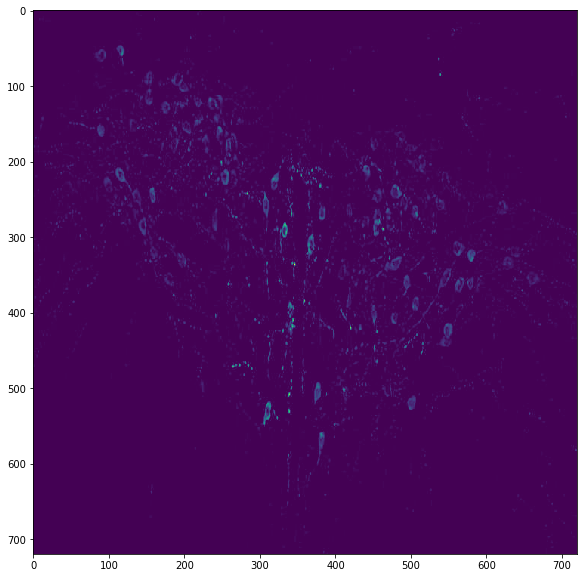

In [6]:
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import io
import boto3
import numpy as np
from skimage import util 
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.io import imread as pngread
from skimage.io import imsave as pngsave
from tifffile import imsave,imread
import cv2
from rolling_ball_filter import rolling_ball_filter
import random
import threading
from skimage.segmentation import mark_boundaries
from skimage import color

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(64,64))
# images/liorp_181106_2_raw.jpg
filename = "/home/ec2-user/SageMaker/itzik_images_cropped/_B37-543-2_07_ver2.tif"
# filename = "/home/ec2-user/SageMaker/images/190221_LV_ver2.tif"
im = imread(filename)
# selem = disk(60)
# inimage = rank.equalize(inimage, selem=selem)  
# im = clahe.apply(im)
# im,_ = rolling_ball_filter(im, ball_radius = 20, spacing = 1, top=False)
im =  cv2.resize(im, (720,720), interpolation = cv2.INTER_AREA)
num = int(''.join(filter(str.isdigit, str(im.dtype)))) - 1
im = img_as_ubyte(exposure.rescale_intensity(im, out_range=(0, 2**num - 1)))
pngsave(filename.replace('tif','jpg'), im)

with open(filename.replace('tif','jpg'), 'rb') as image:
    img = image.read()    
    img = bytearray(img)

fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
ax1 = fig1.add_subplot(1,1,1) 
ax1.imshow(Image.open(io.BytesIO(img)), interpolation='none')
plt.show()

### Run Segmentation

In [ ]:
%%time 
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'image/png'
return_img = ss_predictor.predict(img)

Let us display the segmentation mask.

In [ ]:
from PIL import Image
import numpy as np
import io
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import seaborn as sns
from skimage.color import label2rgb

num_classes = 2
mask = np.array(Image.open(io.BytesIO(return_img)))
distance = ndi.distance_transform_edt(mask)
local_maxi = peak_local_max(distance, labels=mask, footprint=np.ones((3, 3)), indices=False)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=mask)
pngsave('/home/ec2-user/SageMaker/testresult_mask.tif', mask)

fig1 = plt.figure(figsize=(20, 20)) # create a figure with the default size 
ax1 = fig1.add_subplot(2,2,1) 
result = label2rgb(label = labels, image = exposure.rescale_intensity(im.astype(np.float), out_range=(-1, 1)))
ax1.imshow(result)
ax2 = fig1.add_subplot(2,2,2) 
ax2.imshow(labels)
plt.show()
np.unique(labels)

### Delete the endpoint

In [ ]:
sagemaker.Session().delete_endpoint(ss_predictor.endpoint)

# Run inference on deployed model 
### (new notebook run)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/ec2-user/SageMaker/testresult_mask.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/color/colorlabel.py:162: UserWarning: Negative intensities in `image` are not supported
  warn("Negative intensities in `image` are not supported")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


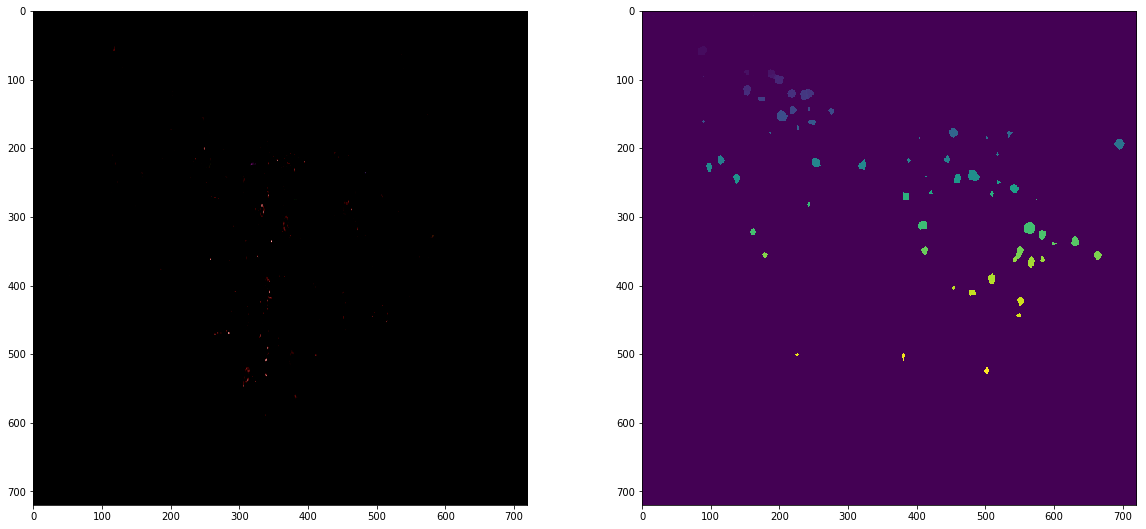

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92], dtype=int32)

In [7]:
import boto3
import json
from sagemaker.amazon.record_pb2 import Record
import mxnet as mx
from scipy import ndimage as ndi
from PIL import Image
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import seaborn as sns
from skimage.color import label2rgb
import numpy as np
import io

endpoint = "fresh-train-trial-190726-1931-020-33fa463c"
 
runtime = boto3.Session().client('sagemaker-runtime')
 
# Read image into memory
# Send image via InvokeEndpoint API
response = runtime.invoke_endpoint(EndpointName=endpoint, ContentType='image/jpeg', Accept = 'image/png', Body=img)
return_img = response['Body'].read()
num_classes = 2
mask = np.array(Image.open(io.BytesIO(return_img)))
distance = ndi.distance_transform_edt(mask)
local_maxi = peak_local_max(distance, labels=mask, footprint=np.ones((3, 3)), indices=False)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=mask)
pngsave('/home/ec2-user/SageMaker/testresult_orig.png', exposure.rescale_intensity(im.astype(np.float), out_range=(-1, 1)))
pngsave('/home/ec2-user/SageMaker/testresult_mask.png', mask)

fig1 = plt.figure(figsize=(20, 20)) # create a figure with the default size 
ax1 = fig1.add_subplot(2,2,1) 
result = label2rgb(label = labels, image = exposure.rescale_intensity(im.astype(np.float), out_range=(-1, 1)))
ax1.imshow(result)
ax2 = fig1.add_subplot(2,2,2) 
ax2.imshow(labels)
plt.show()
np.unique(labels)


### Run a batch job from a saved model

In [12]:
#Batch Job
import sagemaker
from sagemaker import get_execution_role
from IPython.core.debugger import set_trace
role = get_execution_role()
print(role)
sess = sagemaker.Session()

s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3results = s3_resource.Bucket(name='sagemaker-eu-west-1-102554356212')
removesamples = [obj.key for obj in s3results.objects.all() if ("results" in obj.key and ("out" in obj.key or "masks" in obj.key))]
for removeme in removesamples:
    boto3.client('s3').delete_object(Bucket = bucket, Key = removeme)
    
    
transform_job = sagemaker.transformer.Transformer(
    model_name = "fresh-train-trial-190726-1931-020-33fa463c",
#     model_name = "fresh-train-trial-2019-07-18-07-09-22-322",
    instance_count = 1,
    instance_type = 'ml.m5.xlarge',
    strategy = 'SingleRecord',
    assemble_with = 'None',
    output_path = "s3://sagemaker-eu-west-1-102554356212/results/",
    base_transform_job_name='inference-pipelines-batch',
    sagemaker_session=sess,
    accept = 'image/png')
transform_job.transform(data = 's3://sagemaker-eu-west-1-102554356212/submissions/' , 
                        content_type = 'image/jpeg', 
                        split_type = None)
transform_job.wait()

arn:aws:iam::102554356212:role/service-role/AmazonSageMaker-ExecutionRole-20181129T100657


### Read batch processed results and export mask back to S3

In [14]:
# Download data from batch job
import boto3
import mxnet as mx
from PIL import Image
import numpy as np
import io
import os
from skimage.io import imread as pngread
from skimage.io import imsave as pngsave
    
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3results = s3_resource.Bucket(name='sagemaker-eu-west-1-102554356212')
keys = [obj.key for obj in s3results.objects.all()]
os.makedirs('/tmp/results/', exist_ok=True)
for s3_object in keys:
    if not s3_object.endswith("/") and "results" in s3_object and "out" in s3_object:
            s3.meta.client.download_file('sagemaker-eu-west-1-102554356212', s3_object, '/tmp/tempfile.out')
            num_classes = 2
            with open('/tmp/tempfile.out', 'rb') as image:
                img = image.read()    
                img = bytearray(img)
                mask = np.array(Image.open(io.BytesIO(img)))
                print('.'.join(s3_object.split('/')[-1].split('.')[:-1]))
                pngsave('/tmp/results/'+'.'.join(s3_object.split('/')[-1].split('.')[:-1]), mask)
!aws s3 sync '/tmp/results/' 's3://sagemaker-eu-west-1-102554356212/results/masks/'               

190128_LD2.jpg
190128_RD.jpg
190203_RV1.jpg
190212_LD.jpg


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190128_LD2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190128_RD.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190203_RV1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190212_LD.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


190221_LV.jpg
190221_RD1.jpg
190221_RD2.jpg
190221_RD3.jpg
190221_RV1.jpg
190221_RV2.jpg


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190221_LV.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190221_RD1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190221_RD2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190221_RD3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190221_RV1.jpg is a low contrast im

190225_LV.jpg
190225_RV.jpg
190226_LD1.jpg
190226_LD2.jpg


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190225_LV.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190225_RV.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190226_LD1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190226_LD2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


190226_LD3.jpg
190310_LV.jpg
190310_RV.jpg
190514_LD.jpg
190514_RD.jpg


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190226_LD3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190310_LV.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190310_RV.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190514_LD.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190514_RD.jpg is a low contrast image

190515_RD.jpg
190517_LD.jpg
190517_LV.jpg
190517_RD.jpg
190518_LD.jpg
190518_RV.jpg


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190515_RD.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190517_LD.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190517_LV.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190517_RD.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190518_LD.jpg is a low contrast image


190519_RD.jpg


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/results/190519_RD.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


upload: ../../../../tmp/results/190128_LD2.jpg to s3://sagemaker-eu-west-1-102554356212/results/masks/190128_LD2.jpg
upload: ../../../../tmp/results/190221_LV.jpg to s3://sagemaker-eu-west-1-102554356212/results/masks/190221_LV.jpg
upload: ../../../../tmp/results/190221_RD3.jpg to s3://sagemaker-eu-west-1-102554356212/results/masks/190221_RD3.jpg
upload: ../../../../tmp/results/190221_RD2.jpg to s3://sagemaker-eu-west-1-102554356212/results/masks/190221_RD2.jpg
upload: ../../../../tmp/results/190221_RD1.jpg to s3://sagemaker-eu-west-1-102554356212/results/masks/190221_RD1.jpg
upload: ../../../../tmp/results/190212_LD.jpg to s3://sagemaker-eu-west-1-102554356212/results/masks/190212_LD.jpg
upload: ../../../../tmp/results/190128_RD.jpg to s3://sagemaker-eu-west-1-102554356212/results/masks/190128_RD.jpg
upload: ../../../../tmp/results/190221_RV2.jpg to s3://sagemaker-eu-west-1-102554356212/results/masks/190221_RV2.jpg
upload: ../../../../tmp/results/190221_RV1.jpg to s3://sagemaker-eu-we